In [ ]:
# taken from atomai examples on github
# by Maxim Ziatdinov
# https://github.com/pycroscopy/atomai

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

import sys
sys.path.append('/Users/austin/Documents/GitHub/atomai')
import atomai as aoi
print(aoi.__version__)

0.7.8.MAC


In [ ]:
STEM_real = np.load('3DStack13-1-exp.npy')
decoded_imgs = np.load('3DStack13-1-dec.npy')
lattice_coord = np.load('3DStack13-1-coord.npy', allow_pickle=True)[()]

In [ ]:
i = 10 # Choose movie frame

# Squeeze the channels in the predicted image (this is optional)
d_img = np.uint8(decoded_imgs[i]*255)
d_img = cv2.cvtColor(d_img, cv2.COLOR_BGR2GRAY)
# Get coordinates for C and Si atoms
lattice_coord_ = lattice_coord[i]
coord_Si = lattice_coord[i][np.where(lattice_coord[i][:,2]==1)][:,0:2]
coord_C = lattice_coord[i][np.where(lattice_coord[i][:,2]==0)][:,0:2]
# Plotting
fig = plt.figure(figsize = (15, 10), dpi = 100)
ax1 = fig.add_subplot(131)
ax1.imshow(STEM_real[i,:,:,0], vmin=0, vmax=0.3, cmap='gray')
ax1.axis('off')
ax1.set_title('Experimental', fontsize=14)
ax2 = fig.add_subplot(132)
ax2.imshow(d_img, cmap='jet', Interpolation='Gaussian')
ax2.axis('off')
ax2.set_title('DCNN output', fontsize = 14)
ax3 = fig.add_subplot(133)
ax3.scatter(coord_Si[:,1], coord_Si[:,0], c='red', s=1)
ax3.scatter(coord_C[:,1], coord_C[:,0], c='blue', s=1)
ax3.imshow(STEM_real[i,:,:,0], cmap = 'gray')
ax3.axis('off')
ax3.set_title('Atomic coordinates', fontsize = 14)

In [ ]:
window_size = 24
s = aoi.stat.imlocal(
    np.sum(decoded_imgs[..., :-1], -1)[..., None], # convert to a single channel (no background)
    lattice_coord, window_size, 0)

In [ ]:
s.gmm(n_components=16, plot_results=True, random_state=42);

In [13]:
#imstack = s.imgstack[..., 0] # will be used as training/test data
#frames_all = s.imgstack_frames # will need for plotting VAE results
#com_all = s.imgstack_com # will need for plotting VAE results

imstack = np.load('/Users/austin/Desktop/Projects/PdSe Paper/notebooks/VAE_inputs.npy')
imstack = np.transpose(imstack, (2, 0, 1))

from sklearn.model_selection import train_test_split
imstack_train, imstack_test = train_test_split(
    imstack, test_size=0.15, shuffle=True, random_state=0)
print(imstack_train.shape, imstack_test.shape)

(54, 64, 64) (10, 64, 64)


In [15]:
# Ititialize model
in_dim = (64, 64)
vae = aoi.models.VAE(in_dim)
# Train
vae.fit(X_train=imstack_train, X_test=imstack_test, training_cycles=200)

Epoch: 1/200, Training loss: 83.0288, Test loss: 0.0000
Epoch: 2/200, Training loss: 75.5126, Test loss: 0.0000
Epoch: 3/200, Training loss: 71.0650, Test loss: 0.0000
Epoch: 4/200, Training loss: 69.8960, Test loss: 0.0000
Epoch: 5/200, Training loss: 70.2268, Test loss: 0.0000
Epoch: 6/200, Training loss: 69.6055, Test loss: 0.0000
Epoch: 7/200, Training loss: 63.6598, Test loss: 0.0000
Epoch: 8/200, Training loss: 60.7965, Test loss: 0.0000
Epoch: 9/200, Training loss: 59.8550, Test loss: 0.0000
Epoch: 10/200, Training loss: 58.0773, Test loss: 0.0000
Epoch: 11/200, Training loss: 55.7184, Test loss: 0.0000
Epoch: 12/200, Training loss: 51.8581, Test loss: 0.0000
Epoch: 13/200, Training loss: 51.7729, Test loss: 0.0000
Epoch: 14/200, Training loss: 49.6218, Test loss: 0.0000
Epoch: 15/200, Training loss: 48.4070, Test loss: 0.0000
Epoch: 16/200, Training loss: 45.6008, Test loss: 0.0000
Epoch: 17/200, Training loss: 45.3108, Test loss: 0.0000
Epoch: 18/200, Training loss: 44.7632, T

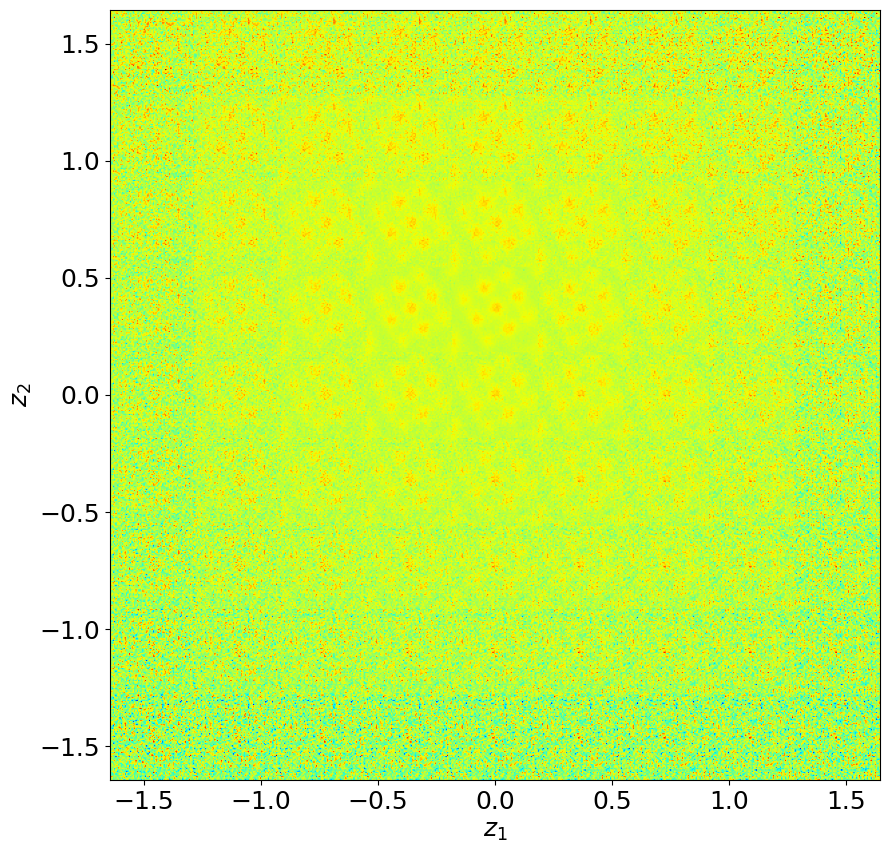

In [16]:
vae.manifold2d(cmap="jet");

In [ ]:
# Ititialize model
in_dim = (window_size, window_size)
rvae = aoi.models.rVAE(in_dim)
# Train
rvae.fit(X_train=imstack_train, X_test=imstack_test, training_cycles=200, batch_size=200)

In [ ]:
rvae.manifold2d(cmap="jet");

In [ ]:
z_mean, z_sd = rvae.encode(imstack)
z1, z2, z3 = z_mean[:,0], z_mean[:, 1:3], z_mean[:, 3:]

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(z1, bins=60, color='gray')
ax[1].hist(z2[:, 0], bins=60, color='gray')
ax[2].hist(z2[:, 1], bins=60, color='gray')
ax[0].set_xlabel("Encoded angle", fontsize=18)
ax[1].set_xlabel("Encoded offset", fontsize=18)
ax[2].set_xlabel("Encoded offset", fontsize=18)
for _ax in fig.axes:
    _ax.set_ylabel("Count", fontsize=18)
    _ax.tick_params(labelsize=15)
plt.subplots_adjust(wspace=0.3)

In [ ]:
frame = 49 # select frame

com_i = com_all[frames_all == frame] # get coordinates for this frame
com_i_Si = lattice_coord[frame] # get Si coordinates for plotting
com_i_Si = com_i_Si[com_i_Si[:,-1]==1.]
z1_i = z1[frames_all == frame] # get latent variables (image) for this frame
z3_i = z3[frames_all == frame] # get latent variables (image) for this frame

col_min0 = z1.min()
col_max0 = z1.max()
col_min1 = z3[:, 0].min()
col_max1 = z3[:, 0].max()
col_min2 = z3[:, 1].min()
col_max2 = z3[:, 1].max()

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(STEM_real[frame,...,0], cmap="gray")
ax[0].scatter(com_i[:, 1], com_i[:, 0], c=z1_i, s=15,
            cmap="jet", vmin=col_min0, vmax=col_max0)
ax[0].set_title("Encoded angle", fontsize=18)
ax[1].imshow(STEM_real[frame,...,0], cmap="gray")
ax[1].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 0], s=15,
            cmap="jet", vmin=col_min1, vmax=col_max1)
ax[1].set_title("Latent variable 1", fontsize=18)
ax[2].imshow(STEM_real[frame,...,0], cmap="gray")
ax[2].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 1], s=15,
              cmap="jet", vmin=col_min2, vmax=col_max2)
ax[2].set_title("Latent variable 2", fontsize=18)
for _ax in fig.axes:
    _ax.scatter(com_i_Si[:, 1], com_i_Si[:, 0], s=35, c='Red')
    _ax.axis(False)
plt.show()